In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split

In [67]:
plt.style.use('ggplot')

# Wczytanie danych

In [68]:
def _process_name(x: str, add: str) -> str:
    if not isinstance(x, str):
        return "unknown"
    x = x.lower()
    if x == "marszałek":
        return f"marszałek {add}"
    x = x.replace("marszałek", "").replace("poseł", "").replace("sekretarz", "").replace("wice", "").replace("senator", "")
    return x

In [69]:
generate_new_sample = True
if generate_new_sample:
    df_sejm_pos = pd.read_pickle("dane_xml/sejm_pos.pkl")
    df_senat_pos = pd.read_pickle("dane_xml/senat_pos.pkl")
    df_sejm_kom = pd.read_pickle("dane_xml/sejm_komisje.pkl")
    df_senat_kom = pd.read_pickle("dane_xml/senat_komisje.pkl")
    krn = pd.read_pickle(f'dane_xml/krn.pkl')

    df_sejm_pos['place'] = 'sejm'
    df_sejm_kom['place'] = 'sejm'
    df_senat_pos['place'] = 'senat'
    df_senat_kom['place'] = 'senat'
    krn['place'] = 'krn'
    for i in range(len(krn['date'])):
        krn['date'][i]=krn['date'][i].replace("i", ",")
        krn['date'][i]=krn['date'][i].split(',')
        krn['date'][i]=krn['date'][i][0]
    
    df_sejm_pos['name'] = df_sejm_pos['name'].apply(lambda x: _process_name(x, "sejmu"))
    df_sejm_kom['name'] = df_sejm_kom['name'].apply(lambda x: _process_name(x, "sejmu"))
    df_senat_kom['name'] = df_senat_kom['name'].apply(lambda x: _process_name(x, "senatu"))
    df_senat_pos['name'] = df_senat_pos['name'].apply(lambda x: _process_name(x, "senatu"))
    df_main = pd.concat([df_sejm_pos, df_sejm_kom, df_senat_kom, df_senat_pos, krn], ignore_index=True)
    df_main.rename({'name': 'author'}, axis=1, inplace=True)
    df_main['date'] = pd.to_datetime(df_main['date'], errors="coerce")

In [70]:
df_main

,date,author,text,place
0,2019-11-12,marszałek sejmu,Otwieram 1. posiedzenie Sejmu Rzeczypospolitej...,sejm
1,2019-11-12,prezydent rzeczypospolitej polskiej andrzej duda,Drodzy Rodacy! Wielce Szanowny Panie Marszałku...,sejm
2,2019-11-12,senior antoni macierewicz,Bardzo dziękuję panu prezydentowi za tak istot...,sejm
3,2019-11-12,antoni macierewicz,Tak mi dopomóż Bóg.,sejm
4,2019-11-12,daniel milewski,Poseł Antoni Macierewicz. Dziękuję bardzo. Pro...,sejm
...,...,...,...,...
2048410,1946-09-20,Ob. Prezydent,"Nie będziemy prowadzili już rozprawy, bo o tym...",krn
2048411,1946-09-20,Poseł ob. Nowak,"Uważam, że odpowiedź nie może nas zadowolić an...",krn
2048412,1946-09-20,Ob. Prezydent,Musimy przegłosować jedną zasadniczą sprawę. W...,krn
2048413,1946-09-20,Poseł ob. Mazur,Wysoka Rado! W związku z moim przerwanym przem...,krn


In [71]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2048415 entries, 0 to 2048414
Data columns (total 4 columns):
 #   Column  Dtype         
---  ------  -----         
 0   date    datetime64[ns]
 1   author  object        
 2   text    object        
 3   place   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 62.5+ MB


## Analiza liczby autorów

In [72]:
print(f"Liczba unikalnych autorów: {len(pd.unique(df_main['author']))}, z czego z sejmu: {len(pd.unique(df_main[df_main.place == 'sejm']['author']))}, z senatu: {len(pd.unique(df_main[df_main.place == 'senat']['author']))} i krn: {len(pd.unique(df_main[df_main.place == 'krn']['author']))}")

Liczba unikalnych autorów: 27478, z czego z sejmu: 23950, z senatu: 4986 i krn: 160


# Rozkład wystąpień per-autor

In [73]:
grouped = df_main.groupby(['place', 'author']).size().reset_index(name='post_count')

result = grouped.groupby('place')['post_count'].agg(['mean', 'std', 'min', 'max'])

print(result)

            mean         std  min    max
place                                   
krn     3.443750   12.084476    1    121
sejm   66.390230  870.256663    1  89313
senat  91.820698  675.610201    1  26182


## Analiza liczby wystąpień w czasie

In [74]:
def plot_in_time(df, ax, x, c):
    df['m'] = df.date.dt.round('D')
    df_fl = df.groupby('m').count()
    sns.scatterplot(df_fl, x='m', y='text', ax=ax, color=c)
    ax.set_xlabel('Data')
    ax.set_ylabel('Aktywność')
    ax.set_title(f'Rozkład aktywności w czasie dla {x}')

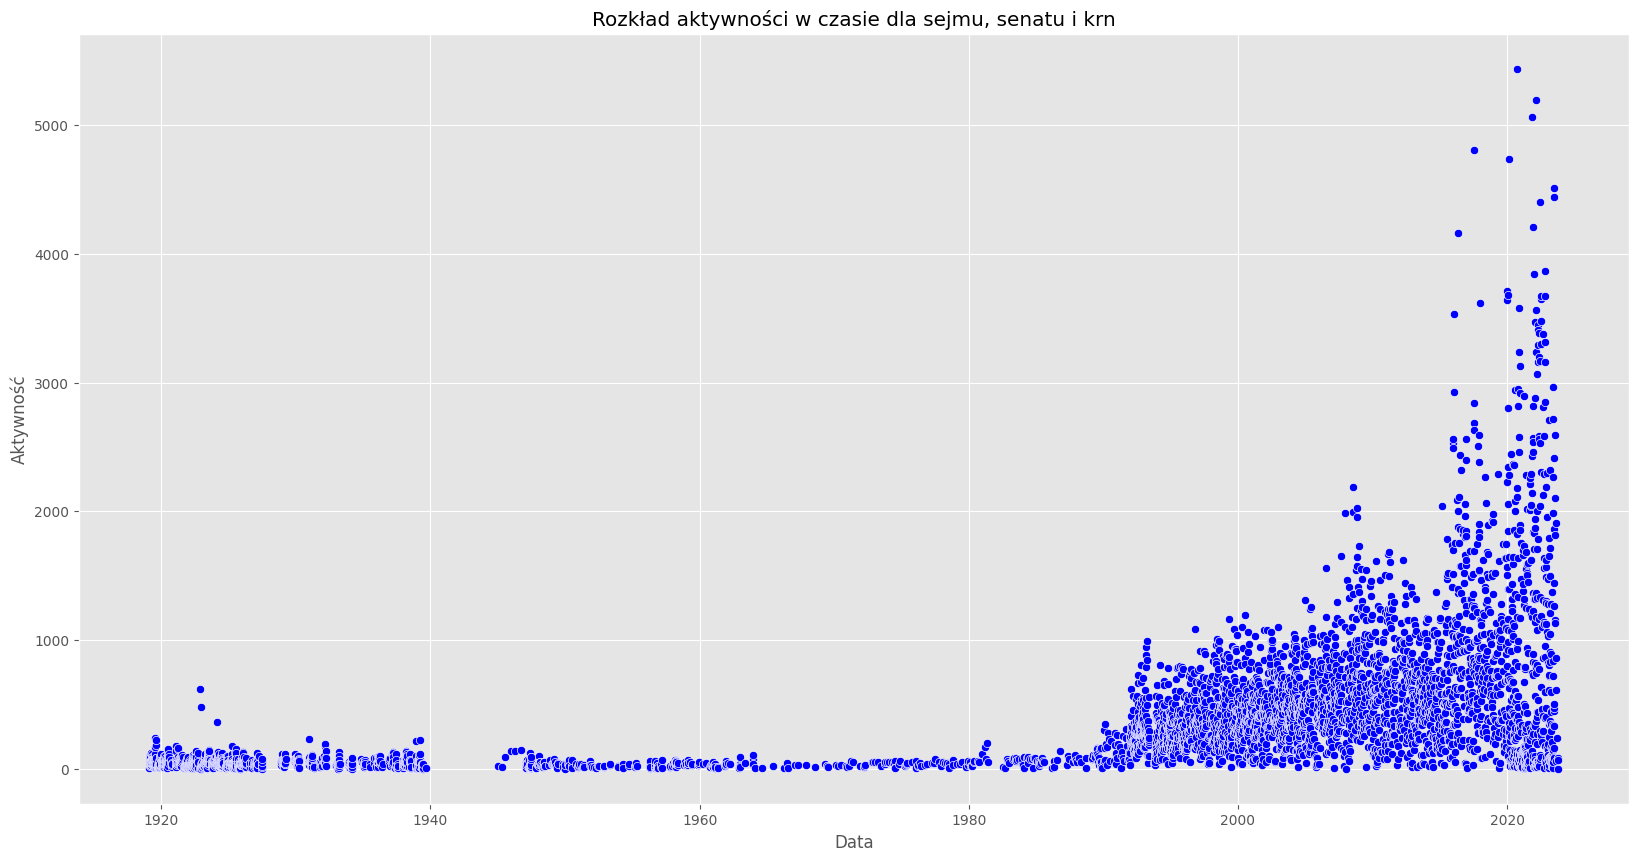

In [75]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_in_time(df_main, ax, 'sejmu, senatu i krn', c='blue')
plt.show()

## Czyszczenie

Dane wyczyszczono wg. następującego schematu:
* Usunięto teskty zawierające podziękowania krótsze niż 5 słów.
* Usunięto teksty zawierające ślubowanie o długości 1 zdania (przyjęto 7 słów )("ślubuję ...)
* Usunięto rekordy, gdzie autor wypowiadał się tylko raz 

In [76]:
df_main['text'] = df_main['text'].str.lower()

In [77]:
df_main = df_main[~((df_main['text'].apply(lambda x: len(str(x).split())) < 5) & (df_main['text'].str.contains('dziękuję')))]
df_main


,date,author,text,place,m
0,2019-11-12,marszałek sejmu,otwieram 1. posiedzenie sejmu rzeczypospolitej...,sejm,2019-11-12
1,2019-11-12,prezydent rzeczypospolitej polskiej andrzej duda,drodzy rodacy! wielce szanowny panie marszałku...,sejm,2019-11-12
2,2019-11-12,senior antoni macierewicz,bardzo dziękuję panu prezydentowi za tak istot...,sejm,2019-11-12
3,2019-11-12,antoni macierewicz,tak mi dopomóż bóg.,sejm,2019-11-12
4,2019-11-12,daniel milewski,poseł antoni macierewicz. dziękuję bardzo. pro...,sejm,2019-11-12
...,...,...,...,...,...
2048410,1946-09-20,Ob. Prezydent,"nie będziemy prowadzili już rozprawy, bo o tym...",krn,1946-09-20
2048411,1946-09-20,Poseł ob. Nowak,"uważam, że odpowiedź nie może nas zadowolić an...",krn,1946-09-20
2048412,1946-09-20,Ob. Prezydent,musimy przegłosować jedną zasadniczą sprawę. w...,krn,1946-09-20
2048413,1946-09-20,Poseł ob. Mazur,wysoka rado! w związku z moim przerwanym przem...,krn,1946-09-20


In [78]:
df_main = df_main[~((df_main['text'].apply(lambda x: len(str(x).split())) < 7) & (df_main['text'].str.contains('ślubuję')))]
df_main

,date,author,text,place,m
0,2019-11-12,marszałek sejmu,otwieram 1. posiedzenie sejmu rzeczypospolitej...,sejm,2019-11-12
1,2019-11-12,prezydent rzeczypospolitej polskiej andrzej duda,drodzy rodacy! wielce szanowny panie marszałku...,sejm,2019-11-12
2,2019-11-12,senior antoni macierewicz,bardzo dziękuję panu prezydentowi za tak istot...,sejm,2019-11-12
3,2019-11-12,antoni macierewicz,tak mi dopomóż bóg.,sejm,2019-11-12
4,2019-11-12,daniel milewski,poseł antoni macierewicz. dziękuję bardzo. pro...,sejm,2019-11-12
...,...,...,...,...,...
2048410,1946-09-20,Ob. Prezydent,"nie będziemy prowadzili już rozprawy, bo o tym...",krn,1946-09-20
2048411,1946-09-20,Poseł ob. Nowak,"uważam, że odpowiedź nie może nas zadowolić an...",krn,1946-09-20
2048412,1946-09-20,Ob. Prezydent,musimy przegłosować jedną zasadniczą sprawę. w...,krn,1946-09-20
2048413,1946-09-20,Poseł ob. Mazur,wysoka rado! w związku z moim przerwanym przem...,krn,1946-09-20


In [79]:
df_main = df_main[~((df_main['text'].apply(lambda x: len(str(x).split())) < 3) )]
df_main

,date,author,text,place,m
0,2019-11-12,marszałek sejmu,otwieram 1. posiedzenie sejmu rzeczypospolitej...,sejm,2019-11-12
1,2019-11-12,prezydent rzeczypospolitej polskiej andrzej duda,drodzy rodacy! wielce szanowny panie marszałku...,sejm,2019-11-12
2,2019-11-12,senior antoni macierewicz,bardzo dziękuję panu prezydentowi za tak istot...,sejm,2019-11-12
3,2019-11-12,antoni macierewicz,tak mi dopomóż bóg.,sejm,2019-11-12
4,2019-11-12,daniel milewski,poseł antoni macierewicz. dziękuję bardzo. pro...,sejm,2019-11-12
...,...,...,...,...,...
2048410,1946-09-20,Ob. Prezydent,"nie będziemy prowadzili już rozprawy, bo o tym...",krn,1946-09-20
2048411,1946-09-20,Poseł ob. Nowak,"uważam, że odpowiedź nie może nas zadowolić an...",krn,1946-09-20
2048412,1946-09-20,Ob. Prezydent,musimy przegłosować jedną zasadniczą sprawę. w...,krn,1946-09-20
2048413,1946-09-20,Poseł ob. Mazur,wysoka rado! w związku z moim przerwanym przem...,krn,1946-09-20


In [80]:
matching_texts = df_main[df_main['text'].str.contains(r'^otwieram(\s\d+)?\.?\sposiedzenie', regex=True)]
matching_texts

/var/folders/bm/ftw8z7yx4x7__tj58fqqzvcm0000gn/T/ipykernel_25065/1875073690.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  matching_texts = df_main[df_main['text'].str.contains(r'^otwieram(\s\d+)?\.?\sposiedzenie', regex=True)]


,date,author,text,place,m
0,2019-11-12,marszałek sejmu,otwieram 1. posiedzenie sejmu rzeczypospolitej...,sejm,2019-11-12
39231,2022-02-08,marszałek sejmu,otwieram posiedzenie. na sekretarzy dzisiejszy...,sejm,2022-02-08
40219,2022-02-23,marszałek sejmu,otwieram posiedzenie. na sekretarzy dzisiejszy...,sejm,2022-02-23
41201,2022-03-08,marszałek sejmu,otwieram posiedzenie. na sekretarzy dzisiejszy...,sejm,2022-03-08
42274,2022-03-23,marszałek sejmu,otwieram posiedzenie. na sekretarzy dzisiejszy...,sejm,2022-03-23
...,...,...,...,...,...
1610488,1990-12-28,józef ślisz,otwieram 40 posiedzenie senatu rzeczpospolitej...,senat,1990-12-28
1611365,NaT,józef ślisz,otwieram 44 posiedzenie senatu. na sekretarzy ...,senat,NaT
1611951,1991-05-10,andrzej stelmachowski,otwieram 48 posiedzenie senatu rzeczpospolitej...,senat,1991-05-10
1612547,NaT,andrzej stelmachowski,otwieram 51 posiedzenie plenarne senatu. jako ...,senat,NaT


In [81]:
df_main = df_main[~df_main['text'].str.contains(r'^otwieram(\s\d+)?\.?\sposiedzenie', regex=True)]
df_main

/var/folders/bm/ftw8z7yx4x7__tj58fqqzvcm0000gn/T/ipykernel_25065/289790471.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_main = df_main[~df_main['text'].str.contains(r'^otwieram(\s\d+)?\.?\sposiedzenie', regex=True)]


,date,author,text,place,m
1,2019-11-12,prezydent rzeczypospolitej polskiej andrzej duda,drodzy rodacy! wielce szanowny panie marszałku...,sejm,2019-11-12
2,2019-11-12,senior antoni macierewicz,bardzo dziękuję panu prezydentowi za tak istot...,sejm,2019-11-12
3,2019-11-12,antoni macierewicz,tak mi dopomóż bóg.,sejm,2019-11-12
4,2019-11-12,daniel milewski,poseł antoni macierewicz. dziękuję bardzo. pro...,sejm,2019-11-12
201,2019-11-12,anna siarkowska,ślubuję. tak mi dopomóż panie boże wszechmogąc...,sejm,2019-11-12
...,...,...,...,...,...
2048410,1946-09-20,Ob. Prezydent,"nie będziemy prowadzili już rozprawy, bo o tym...",krn,1946-09-20
2048411,1946-09-20,Poseł ob. Nowak,"uważam, że odpowiedź nie może nas zadowolić an...",krn,1946-09-20
2048412,1946-09-20,Ob. Prezydent,musimy przegłosować jedną zasadniczą sprawę. w...,krn,1946-09-20
2048413,1946-09-20,Poseł ob. Mazur,wysoka rado! w związku z moim przerwanym przem...,krn,1946-09-20


In [82]:
author_counts = df_main['author'].value_counts()
authors_to_remove = author_counts[author_counts == 1].index
len(authors_to_remove)

9854

In [83]:
df_main = df_main[~df_main['author'].isin(authors_to_remove)]
df_main

,date,author,text,place,m
1,2019-11-12,prezydent rzeczypospolitej polskiej andrzej duda,drodzy rodacy! wielce szanowny panie marszałku...,sejm,2019-11-12
2,2019-11-12,senior antoni macierewicz,bardzo dziękuję panu prezydentowi za tak istot...,sejm,2019-11-12
3,2019-11-12,antoni macierewicz,tak mi dopomóż bóg.,sejm,2019-11-12
4,2019-11-12,daniel milewski,poseł antoni macierewicz. dziękuję bardzo. pro...,sejm,2019-11-12
201,2019-11-12,anna siarkowska,ślubuję. tak mi dopomóż panie boże wszechmogąc...,sejm,2019-11-12
...,...,...,...,...,...
2048410,1946-09-20,Ob. Prezydent,"nie będziemy prowadzili już rozprawy, bo o tym...",krn,1946-09-20
2048411,1946-09-20,Poseł ob. Nowak,"uważam, że odpowiedź nie może nas zadowolić an...",krn,1946-09-20
2048412,1946-09-20,Ob. Prezydent,musimy przegłosować jedną zasadniczą sprawę. w...,krn,1946-09-20
2048413,1946-09-20,Poseł ob. Mazur,wysoka rado! w związku z moim przerwanym przem...,krn,1946-09-20


### Dane po czyszczeniu

In [84]:
print(f"Liczba unikalnych autorów po oczyszczeniu: {len(pd.unique(df_main['author']))}, z czego z sejmu: {len(pd.unique(df_main[df_main.place == 'sejm']['author']))}, z senatu: {len(pd.unique(df_main[df_main.place == 'senat']['author']))} i krn: {len(pd.unique(df_main[df_main.place == 'krn']['author']))}")

Liczba unikalnych autorów po oczyszczeniu: 16348, z czego z sejmu: 14701, z senatu: 3173 i krn: 59


In [85]:
grouped = df_main.groupby(['place', 'author']).size().reset_index(name='post_count')

result = grouped.groupby('place')['post_count'].agg(['mean', 'std', 'min', 'max'])

print(result)

             mean         std  min    max
place                                    
krn      7.593220   19.249826    2    121
sejm    97.817699  974.826640    1  82920
senat  123.427041  711.322561    1  21991


/var/folders/bm/ftw8z7yx4x7__tj58fqqzvcm0000gn/T/ipykernel_25065/3757745979.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['m'] = df.date.dt.round('D')


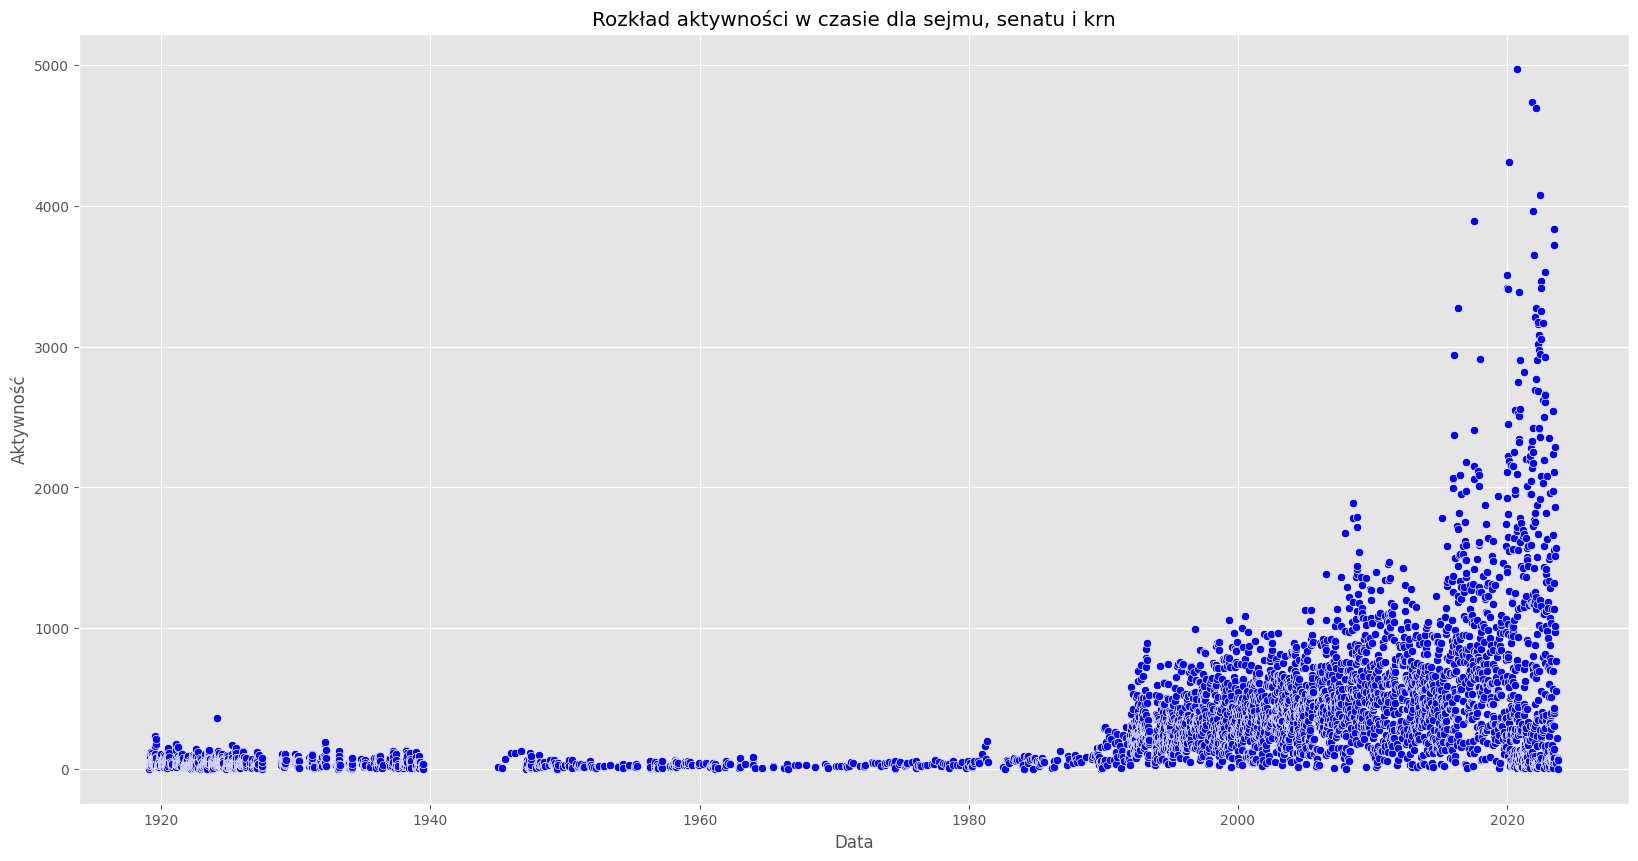

In [86]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_in_time(df_main, ax, 'sejmu, senatu i krn', c='blue')
plt.show()

In [87]:
df_main.to_pickle("data/sejm_senat_krn_no_sentiment.pkl")

In [88]:
df_main = pd.read_pickle("data/sejm_senat_krn_no_sentiment.pkl")

# Analiza językowa i sentyment

In [36]:
date_counts = df_main['date'].value_counts()
dates_to_keep = date_counts[date_counts > 1].index
df_main_filtered = df_main[df_main['date'].isin(dates_to_keep)]
df_main_filtered

,date,author,text,place,m
1,2019-11-12,prezydent rzeczypospolitej polskiej andrzej duda,drodzy rodacy! wielce szanowny panie marszałku...,sejm,2019-11-12
2,2019-11-12,senior antoni macierewicz,bardzo dziękuję panu prezydentowi za tak istot...,sejm,2019-11-12
3,2019-11-12,antoni macierewicz,tak mi dopomóż bóg.,sejm,2019-11-12
4,2019-11-12,daniel milewski,poseł antoni macierewicz. dziękuję bardzo. pro...,sejm,2019-11-12
201,2019-11-12,anna siarkowska,ślubuję. tak mi dopomóż panie boże wszechmogąc...,sejm,2019-11-12
...,...,...,...,...,...
2048410,1946-09-20,Ob. Prezydent,"nie będziemy prowadzili już rozprawy, bo o tym...",krn,1946-09-20
2048411,1946-09-20,Poseł ob. Nowak,"uważam, że odpowiedź nie może nas zadowolić an...",krn,1946-09-20
2048412,1946-09-20,Ob. Prezydent,musimy przegłosować jedną zasadniczą sprawę. w...,krn,1946-09-20
2048413,1946-09-20,Poseł ob. Mazur,wysoka rado! w związku z moim przerwanym przem...,krn,1946-09-20


In [37]:
df_ss, _ = train_test_split(df_main_filtered, stratify=df_main_filtered['date'].dt.round('D'), train_size=0.05)

## Tokenizacja

In [38]:
import spacy
nlp = spacy.load('pl_core_news_sm')

In [39]:
import tqdm
tqdm.tqdm.pandas()

In [40]:
def tokenize_text(text):
    doc = nlp(text)
    return [token.text for token in doc]

In [41]:
df_ss["tokens"] = df_ss["text"].progress_apply(tokenize_text)

100%|██████████| 89569/89569 [1:01:36<00:00, 24.23it/s]


## Liczba słów i tokenów w korpusie

In [42]:
def count_unique_tokens(df):

    tokens = []
    for tok in df["tokens"]:
        tokens.extend(tok)

    unique_tokens = set(tokens)
    num_unique_tokens = len(unique_tokens)
    return num_unique_tokens

In [43]:
print(f'Liczba tokenów w korpusie: {count_unique_tokens(df_ss)} W tym w sejmie: {count_unique_tokens(df_ss[df_ss.place == "sejm"])}, senacie: {count_unique_tokens(df_ss[df_ss.place == "senat"])} i krn:{count_unique_tokens(df_ss[df_ss.place == "krn"])}')

Liczba tokenów w korpusie: 221891 W tym w sejmie: 205206, senacie: 94070 i krn:2154


In [44]:
df_ss["nt"] = df_ss["tokens"].progress_apply(lambda x: len(x))

100%|██████████| 89569/89569 [00:00<00:00, 1624089.95it/s]


In [47]:
print(f'Średnia liczba tokenów w korpusie: {df_ss["nt"].mean()} W tym w sejmie: {df_ss[df_ss.place == "sejm"]["nt"].mean()}, senacie: {df_ss[df_ss.place == "senat"]["nt"].mean()} i krn: {df_ss[df_ss.place == "krn"]["nt"].mean()}')

Średnia liczba tokenów w korpusie: 165.77568131831325 W tym w sejmie: 171.76076269500726, senacie: 143.68665205593823 i krn: 255.8695652173913


## Rozkład liczby słów na wystąpienie w czasie

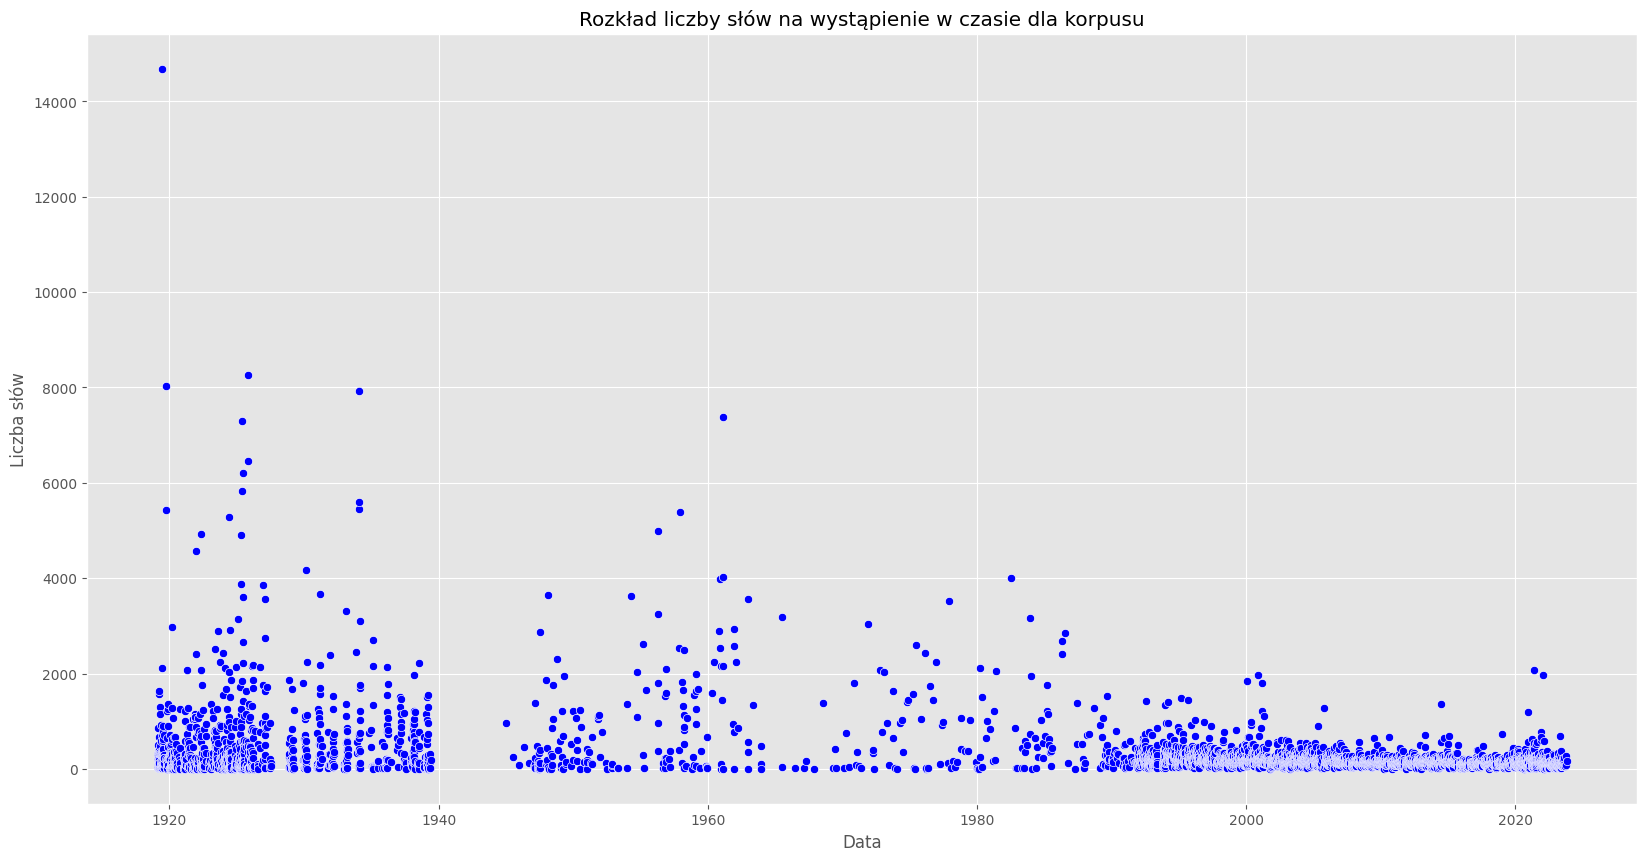

In [48]:
fig, ax = plt.subplots(figsize=(20, 10))
df_ss['m'] = df_ss.date.dt.round('D')
df_fl = df_ss.groupby('m')[["nt", "date"]].mean()
sns.scatterplot(df_fl, x='m', y='nt', ax=ax, color="blue")
ax.set_xlabel('Data')
ax.set_ylabel('Liczba słów')
ax.set_title(f'Rozkład liczby słów na wystąpienie w czasie dla korpusu')
plt.show()

## Liczba wystąpień części zdania

In [49]:
def count_pos(text):
    doc = nlp(text)
    pos_counts = {}
    for token in doc:
        pos = token.pos_
        if pos in pos_counts:
            pos_counts[pos] += 1
        else:
            pos_counts[pos] = 1
    return pos_counts

In [50]:
df_ss["pos_counts"] = df_ss["text"].progress_apply(count_pos)

100%|██████████| 89569/89569 [1:01:11<00:00, 24.39it/s]


In [51]:
pos_df = df_ss['pos_counts'].apply(pd.Series)
df_ss = pd.concat([df_ss, pos_df], axis=1)
df_ss = df_ss.drop('pos_counts', axis=1)

In [52]:
df_ss.columns

Index(['date', 'author', 'text', 'place', 'm', 'tokens', 'nt', 'VERB', 'NOUN',
       'PUNCT', 'ADP', 'PROPN', 'ADJ', 'DET', 'PART', 'SCONJ', 'AUX', 'X',
       'CCONJ', 'PRON', 'ADV', 'NUM', 'INTJ', 'SYM', 'SPACE'],
      dtype='object')

In [53]:
df_ss[df_ss.columns[7:]] = df_ss[df_ss.columns[7:]].fillna(0)

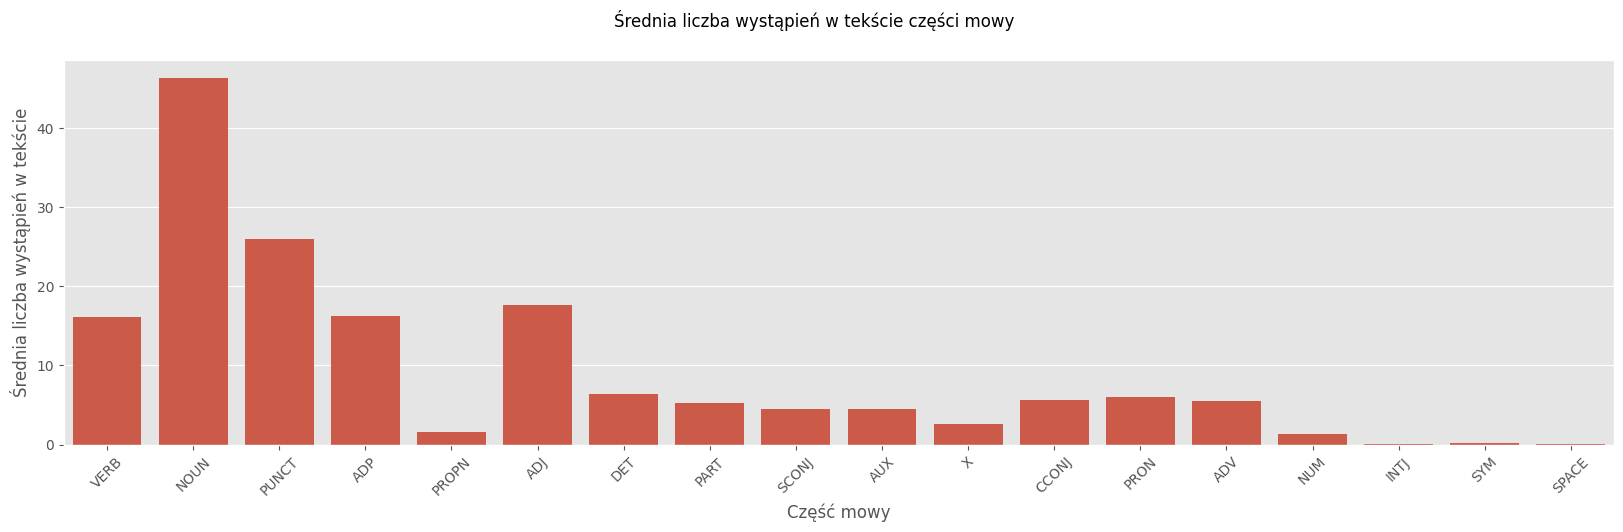

In [55]:
fig, ax = plt.subplots(figsize=(20,5))
sns.barplot(df_ss[df_ss.columns[7:]].mean(), ax=ax)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

ax.set_xlabel('Część mowy')
ax.set_ylabel('Średnia liczba wystąpień w tekście')
fig.suptitle('Średnia liczba wystąpień w tekście części mowy')
plt.show()

# Analiza tematyczna

In [56]:
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from stop_words import get_stop_words

stop_words = get_stop_words('polish') + ['http', 'https', 'amp', 'com']

In [57]:
dictionary = Dictionary(df_ss['tokens'])
corpus = [dictionary.doc2bow(doc) for doc in df_ss['tokens']]

# Build an LDA model
lda_model = LdaModel(corpus, num_topics=6, id2word=dictionary, passes=10)

# Assign topics to documents and add a 'topic' column to the DataFrame
df_ss['topic'] = [max(lda_model[doc], key=lambda x: x[1])[0] for doc in corpus]

In [58]:
df_ss

,date,author,text,place,m,tokens,nt,VERB,NOUN,PUNCT,...,AUX,X,CCONJ,PRON,ADV,NUM,INTJ,SYM,SPACE,topic
473628,2003-09-18,tomasz nałęcz,dziękuję panu posłowi. proszę o zabranie głosu...,sejm,2003-09-18,"[dziękuję, panu, posłowi, ., proszę, o, zabran...",22,2.0,10.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1353438,2020-09-24,legislator katarzyna abramowicz,"do tej poprawki nie mamy uwag. rozumiemy, że t...",sejm,2020-09-24,"[do, tej, poprawki, nie, mamy, uwag, ., rozumi...",52,3.0,10.0,10.0,...,4.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,4
454221,2003-03-13,tomasz nałęcz,dziękuję panu posłowi. proszę o zabranie głosu...,sejm,2003-03-13,"[dziękuję, panu, posłowi, ., proszę, o, zabran...",21,2.0,11.0,2.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
907826,2014-11-27,małgorzata sekuła-szmajdzińska,pani marszałek! pani minister! wysoka izbo! pr...,sejm,2014-11-27,"[pani, marszałek, !, pani, minister, !, wysoka...",518,55.0,141.0,86.0,...,15.0,8.0,11.0,19.0,18.0,0.0,0.0,0.0,0.0,4
194157,1993-12-10,grażyna kotowicz,panie marszałku! wysoka izbo! w tym artykule c...,sejm,1993-12-10,"[panie, marszałku, !, wysoka, izbo, !, w, tym,...",105,12.0,33.0,15.0,...,0.0,5.0,0.0,2.0,5.0,0.0,0.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1939520,2016-04-28,andrzej stanisławek,pierwsze pytanie dotyczy ośrodków doradztwa ro...,senat,2016-04-28,"[pierwsze, pytanie, dotyczy, ośrodków, doradzt...",130,17.0,36.0,19.0,...,5.0,0.0,4.0,7.0,3.0,1.0,0.0,0.0,0.0,4
184260,1993-03-03,władysław wrona,"(dobrze, że przyszedłem na czas.)",sejm,1993-03-03,"[(, dobrze, ,, że, przyszedłem, na, czas, ., )]",9,1.0,1.0,4.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4
690643,2009-01-22,stefan niesiołowski,bardzo dziękuję panu ministrowi. proszę o zabr...,sejm,2009-01-22,"[bardzo, dziękuję, panu, ministrowi, ., proszę...",31,5.0,14.0,6.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0
1999298,2017-12-20,piotr florek,"na tej samej liście liczy się ten, który jest ...",senat,2017-12-20,"[na, tej, samej, liście, liczy, się, ten, ,, k...",599,74.0,81.0,125.0,...,30.0,1.0,22.0,45.0,22.0,5.0,4.0,0.0,0.0,4


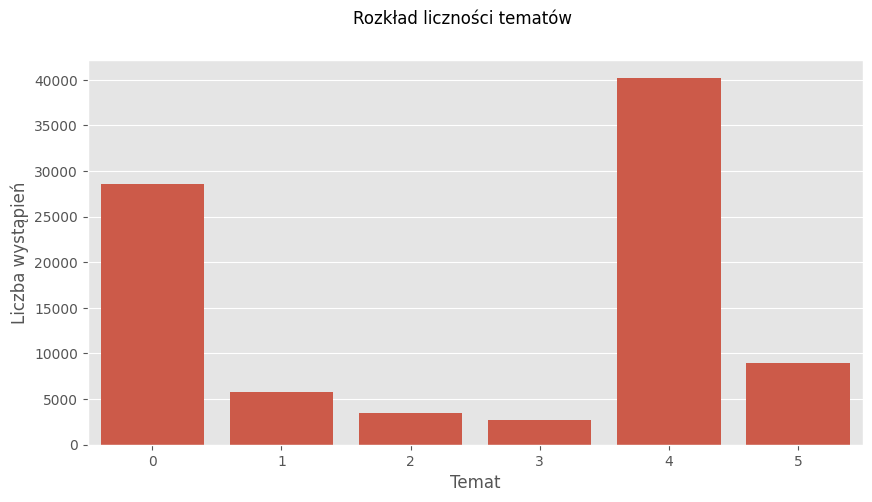

In [59]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.countplot(df_ss, x='topic', ax=ax)
ax.set_xlabel('Temat')
ax.set_ylabel('Liczba wystąpień')
fig.suptitle('Rozkład liczności tematów')
plt.show()

In [61]:
for t in pd.unique(df_ss.topic):
    df_t = df_ss[df_ss.topic == t]
    print(f'Temat {t}:')

    for tx in df_t.text[:5]:
        print('\t' + tx)


Temat 0:
	dziękuję panu posłowi. proszę o zabranie głosu pana posła marka kotlinowskiego, występującego w imieniu klubu parlamentarnego ligi polskich rodzin.
	dziękuję panu posłowi. proszę o zabranie głosu pana posła marka muszyńskiego występującego w imieniu klubu parlamentarnego prawo i sprawiedliwość.
	panie pośle, to już było ostatnie pytanie. dziękuję.
	dziękuję panu posłowi. lista mówców została wyczerpana. proszę o zabranie głosu podsekretarza stanu w ministerstwie edukacji narodowej panią annę urbanowicz.
	pani senator zdrojewska. bardzo proszę.
Temat 4:
	do tej poprawki nie mamy uwag. rozumiemy, że te kolejne punkty będą poddane pod głosowanie odrębnie, ponieważ… kolejne punkty z poprawki zgłoszone jako poprawka nr 13, od 1, 2, 3, 4… to są odrębne kwestie i będziemy je poddawać pod głosowanie kolejno.
	pani marszałek! pani minister! wysoka izbo! proponowane zmiany zawarte w poselskim projekcie ustawy o zmianie ustawy kodeks karny wykonawczy, druk nr 2874, powinny czynić zadość

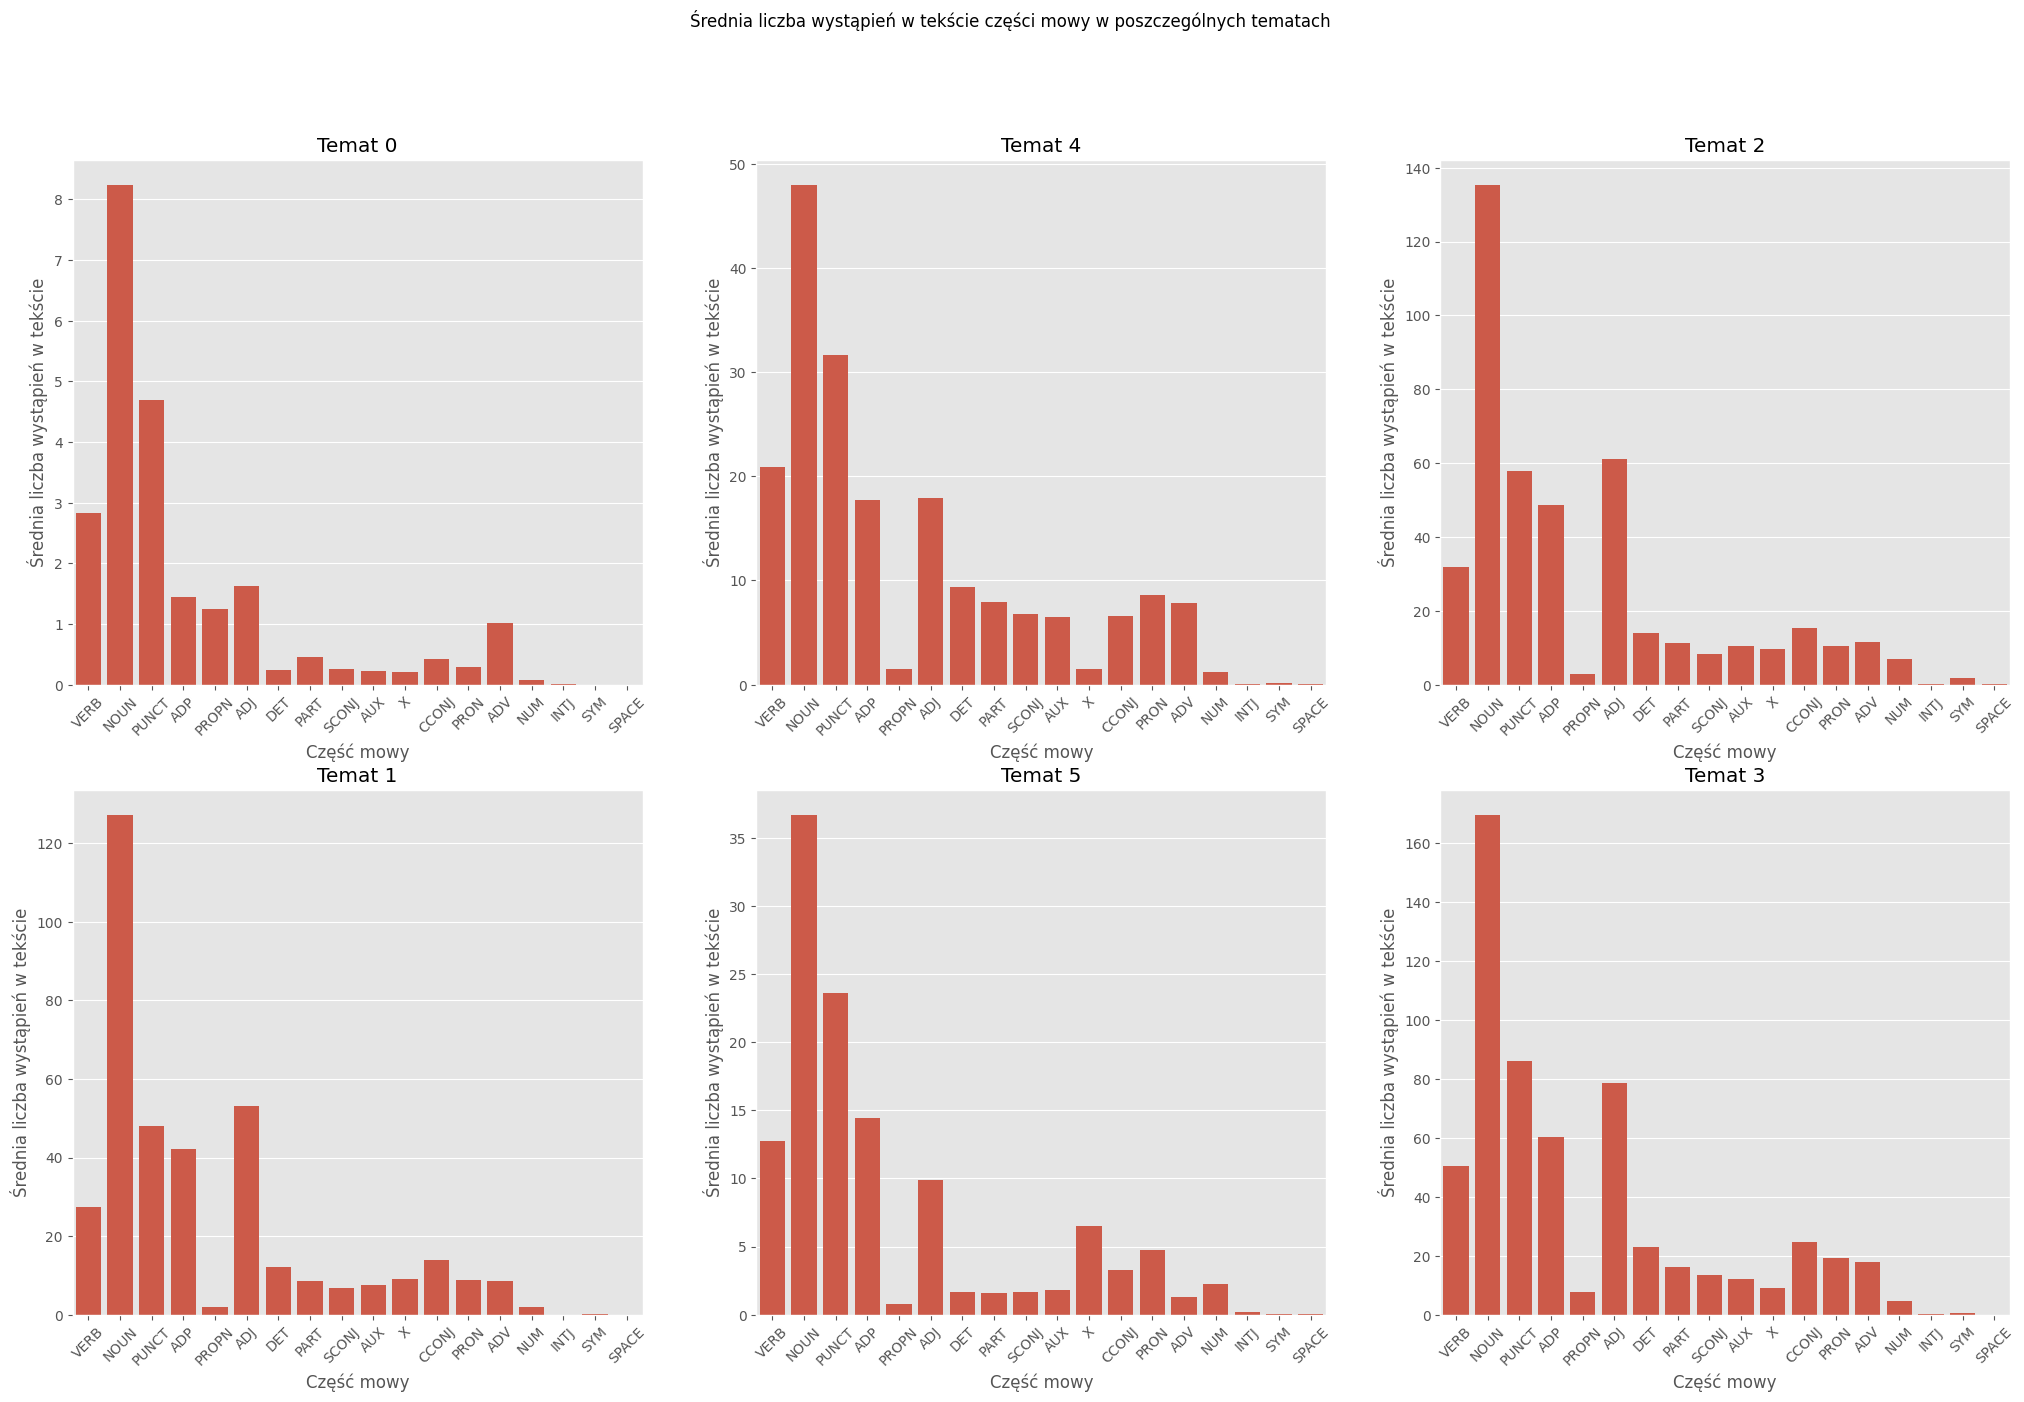

In [63]:
fig, ax = plt.subplots(2, 3, figsize=(25, 15))

topic_iter = iter(pd.unique(df_ss.topic))

for i in range(2):
    for j in range(3):
        t = next(topic_iter)
        df_t = df_ss[df_ss.topic == t]
        sns.barplot(df_t[df_t.columns[7:-1]].mean(), ax=ax[i, j])
        for tick in ax[i, j].get_xticklabels():
            tick.set_rotation(45)
        
        ax[i, j].set_xlabel('Część mowy')
        ax[i, j].set_ylabel('Średnia liczba wystąpień w tekście')
        ax[i, j].set_title(f'Temat {t}')
fig.suptitle('Średnia liczba wystąpień w tekście części mowy w poszczególnych tematach')
plt.show()    

# Analiza sentymentu

In [89]:
import re
def remove_tags_and_hashtags(text):
    # Remove hashtags and @ tags
    text = re.sub(r'#', '', text)
    text = re.sub(r'@', '', text)
    return text.strip()

df_main["text"] = df_main["text"].apply(remove_tags_and_hashtags)
df_main

,date,author,text,place,m
1,2019-11-12,prezydent rzeczypospolitej polskiej andrzej duda,drodzy rodacy! wielce szanowny panie marszałku...,sejm,2019-11-12
2,2019-11-12,senior antoni macierewicz,bardzo dziękuję panu prezydentowi za tak istot...,sejm,2019-11-12
3,2019-11-12,antoni macierewicz,tak mi dopomóż bóg.,sejm,2019-11-12
4,2019-11-12,daniel milewski,poseł antoni macierewicz. dziękuję bardzo. pro...,sejm,2019-11-12
201,2019-11-12,anna siarkowska,ślubuję. tak mi dopomóż panie boże wszechmogąc...,sejm,2019-11-12
...,...,...,...,...,...
2048410,1946-09-20,Ob. Prezydent,"nie będziemy prowadzili już rozprawy, bo o tym...",krn,1946-09-20
2048411,1946-09-20,Poseł ob. Nowak,"uważam, że odpowiedź nie może nas zadowolić an...",krn,1946-09-20
2048412,1946-09-20,Ob. Prezydent,musimy przegłosować jedną zasadniczą sprawę. w...,krn,1946-09-20
2048413,1946-09-20,Poseł ob. Mazur,wysoka rado! w związku z moim przerwanym przem...,krn,1946-09-20


In [90]:
from textblob import TextBlob
def sentiment_analysis():
 def getSubjectivity(text):
   return TextBlob(text).sentiment.subjectivity
  
 #Create a function to get the polarity
 def getPolarity(text):
   return TextBlob(text).sentiment.polarity
  
 #Create two new columns ‘Subjectivity’ & ‘Polarity’
 df_main['TextBlob_Subjectivity'] = df_main['text'].apply(getSubjectivity)
 df_main['TextBlob_Polarity'] = df_main['text'].apply(getPolarity)

sentiment_analysis()
df_main

,date,author,text,place,m,TextBlob_Subjectivity,TextBlob_Polarity
1,2019-11-12,prezydent rzeczypospolitej polskiej andrzej duda,drodzy rodacy! wielce szanowny panie marszałku...,sejm,2019-11-12,0.0000,0.0000
2,2019-11-12,senior antoni macierewicz,bardzo dziękuję panu prezydentowi za tak istot...,sejm,2019-11-12,0.0625,-0.0625
3,2019-11-12,antoni macierewicz,tak mi dopomóż bóg.,sejm,2019-11-12,0.0000,0.0000
4,2019-11-12,daniel milewski,poseł antoni macierewicz. dziękuję bardzo. pro...,sejm,2019-11-12,0.0000,0.0000
201,2019-11-12,anna siarkowska,ślubuję. tak mi dopomóż panie boże wszechmogąc...,sejm,2019-11-12,0.0000,0.0000
...,...,...,...,...,...,...,...
2048410,1946-09-20,Ob. Prezydent,"nie będziemy prowadzili już rozprawy, bo o tym...",krn,1946-09-20,0.0000,0.0000
2048411,1946-09-20,Poseł ob. Nowak,"uważam, że odpowiedź nie może nas zadowolić an...",krn,1946-09-20,0.0000,0.0000
2048412,1946-09-20,Ob. Prezydent,musimy przegłosować jedną zasadniczą sprawę. w...,krn,1946-09-20,0.0000,0.0000
2048413,1946-09-20,Poseł ob. Mazur,wysoka rado! w związku z moim przerwanym przem...,krn,1946-09-20,0.0000,0.0000


In [91]:
df_main['TextBlob_Polarity'].describe()

count    1.830100e+06
mean     4.040340e-03
std      6.112033e-02
min     -1.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: TextBlob_Polarity, dtype: float64

In [92]:
df_main['TextBlob_Subjectivity'].describe()

count    1.830100e+06
mean     1.446272e-02
std      8.457749e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: TextBlob_Subjectivity, dtype: float64

In [ ]:
df_main.to_pickle("data/sejm_senat_krn_with_textblob.pkl")

In [93]:
from tqdm import tqdm
import math
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

RECREATE_SENTIMENT = True

if RECREATE_SENTIMENT:
    with torch.no_grad():
        # id2label = {0: "negative", 1: "neutral", 2: "positive"}
        mps_device = torch.device("mps")
        id2label = {0: -1, 1: 0, 2: 1}
        tokenizer = AutoTokenizer.from_pretrained(
            "Voicelab/herbert-base-cased-sentiment"
        )
        model = AutoModelForSequenceClassification.from_pretrained(
            "Voicelab/herbert-base-cased-sentiment"
        ).to(mps_device)
        df_main['sentiment_herbert'] = np.NaN
        sentiment_list = []
        for i in tqdm(range(len(df_main))):
            input = df_main['text'].iloc[i]
            encoding = tokenizer(
            input,
            add_special_tokens=True,
            return_token_type_ids=True,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            ).to("mps")
            output = model(**encoding).logits.to("cpu").detach().numpy()
            prediction = id2label[np.argmax(output)]
            sentiment_list.append(prediction)

/Users/martynagrygiel/Documents/studia/sem2/amc/wiatrolapy/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  6%|▌         | 106235/1830100 [1:32:15<24:56:58, 19.19it/s]


KeyboardInterrupt: 

In [ ]:
df_main['sentiment_herbert'] = sentiment_list
df_main

In [ ]:
df_main.to_pickle("data/sejm_senat_krn_with_sentiment.pkl")